# Coloring t-SNE

[t-SNE](https://lvdmaaten.github.io/tsne/) is great at capturing a combination of the local and global structure of a dataset in 2d or 3d. But when plotting points in 2d, there are often interesting patterns in the data that only come out as "texture" in the point cloud. When the plot is colored appropriately, these patterns can be made more clear.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA, FastICA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

In [5]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])


First we load some data: a 128 dimensional embedding output from a VAE, and a 2 dimensional representation of those vectors based on running t-SNE.

In [ ]:
data128=X.as_matrix()
model = TSNE(n_components=2, random_state=0)
data2=model.fit_transform(data128) 

## Raw Data

When we visualize the raw data itself the "texture" is clear, but not as clear as the different "islands" and clusters.

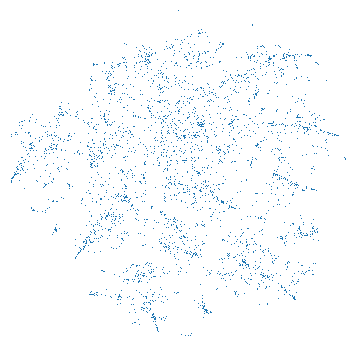

In [46]:
def plot_tsne(xy, colors=None, alpha=0.25, figsize=(6,6), s=0.5, cmap='hsv'):
    plt.figure(figsize=figsize, facecolor='white')
    plt.margins(0)
    plt.axis('off')
    fig = plt.scatter(xy[:,0], xy[:,1],
                c=colors, # set colors of markers
                cmap=cmap, # set color map of markers
                marker=',', # use smallest available marker (square)
                s=1, # set marker size. single pixel is 0.5 on retina, 1.0 otherwise
                lw=0, # don't use edges
                edgecolor='') # don't use edges
    # remove all axes and whitespace / borders
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()
    
plot_tsne(data2)

One way of pulling out a real feature from the data is to look at the nearest neighbors in 2d and see how far away they are on average in the original high dimensional space. This suggestion comes from [Martin Wattenberg](https://twitter.com/wattenberg). First we compute the indices for all the nearest neighbors:

In [47]:
nns = NearestNeighbors(n_neighbors=10).fit(data2)
%time distances, indices = nns.kneighbors(data2)

Wall time: 19.5 ms


And then we compute the distances in high dimensional space, and normalize them between 0 and 1.

In [48]:
distances = []
for point, neighbor_indices in zip(data128, indices):
    neighbor_points = data128[neighbor_indices[1:]] # skip the first one, which should be itself
    cur_distances = np.sum([euclidean(point, neighbor) for neighbor in neighbor_points])
    distances.append(cur_distances)
distances = np.asarray(distances)
distances -= distances.min()
distances /= distances.max()

In this case the distances look sort of gaussian with a long tail. We clip the ends to draw out the details in the colors.

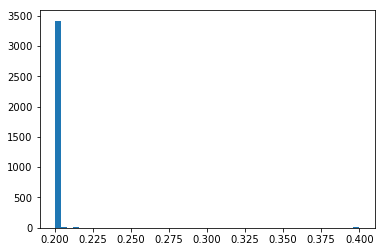

In [49]:
plt.hist(np.clip(distances, 0.2, 0.4), bins=50)
plt.show()

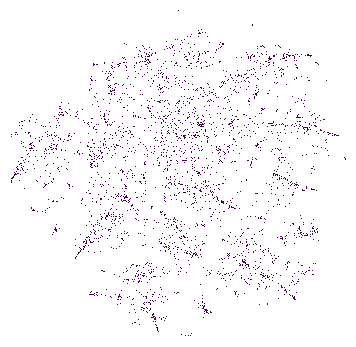

In [51]:
plot_tsne(data2, np.clip(distances, 0.9, 0.9), cmap='viridis')

## 3D t-SNE

One technique is to compute t-SNE in 3D and use the results as colors. This can take a long time to compute with large datasets. This is the technique that was used for the [Infinite Drum Machine](https://aiexperiments.withgoogle.com/drum-machine).

```python
from bhtsne import tsne
data3 = tsne(data128, dimensions=3)
data3 -= np.min(data3, axis=0)
data3 /= np.max(data3, axis=0)
plot_tsne(data2, data3)
```

## 3D/24D PCA

Another approach is to use PCA, which is must faster but does not show as much structure in the data.

Wall time: 323 ms


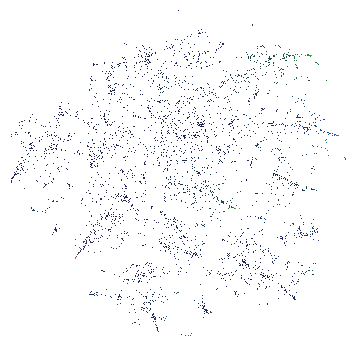

In [52]:
pca = IncrementalPCA(n_components=3)
%time pca_projection = pca.fit_transform(data128)
pca_projection -= np.min(pca_projection, axis=0)
pca_projection /= np.max(pca_projection, axis=0)
plot_tsne(data2, pca_projection)

Instead of using PCA to 3D, we can also do PCA to 24 dimensions, comparing the dimensions to the median of each, and using those comparisons as bits in a 24-bit color. This suggestion comes from [Mario Klingemann](https://twitter.com/quasimondo) This technique can work well with only 12 dimensions (4 bits per color). It doesn't make sense in a "continuous" space (normalizing and multiplying the shuffled bits by the basis directly, rather than testing against the median first). That just makes the colors all muddled, more similar to the 3D PCA.

Wall time: 308 ms


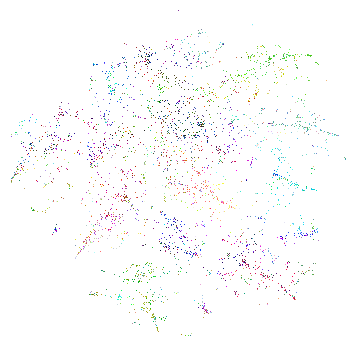

In [53]:
def projection_to_colors(projection, bits_per_channel=8):
    basis = 2**np.arange(bits_per_channel)[::-1]
    basis = np.hstack([basis, basis, basis])
    shuffled = np.hstack([projection[:,0::3], projection[:,1::3], projection[:,2::3]])
    bits = (shuffled > np.median(shuffled, axis=0)) * basis
    # if we stacked into a 3d tensor we could do this a little more efficiently
    colors = np.vstack([bits[:,:(bits_per_channel)].sum(axis=1),
                        bits[:,(bits_per_channel):(2*bits_per_channel)].sum(axis=1),
                        bits[:,(2*bits_per_channel):(3*bits_per_channel)].sum(axis=1)]).astype(float).T
    return colors / (2**bits_per_channel - 1)
    
def pack_binary_pca(data, bits_per_channel=8):
    bits_per_color = 3 * bits_per_channel
    pca = IncrementalPCA(n_components=bits_per_color)
    pca_projection = pca.fit_transform(data)
    return projection_to_colors(pca_projection, bits_per_channel)

%time colors = pack_binary_pca(data128, 8)
plot_tsne(data2, colors)

## 3D/24D ICA

Another approach is to use ICA, which can be a little slower than PCA, but shows different features depending on the data.

Wall time: 206 ms


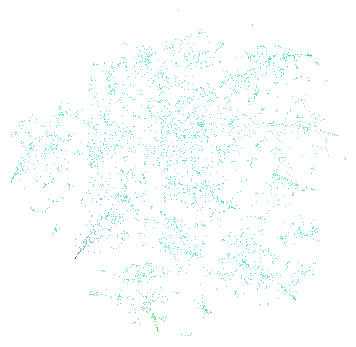

In [54]:
ica = FastICA(n_components=3)
%time ica_projection = ica.fit_transform(data128)
ica_projection -= np.min(ica_projection, axis=0)
ica_projection /= np.max(ica_projection, axis=0)
plot_tsne(data2, ica_projection)

We can also do ICA to 24 dimensions and pack it into colors. This might make less sense than PCA theoretically.

Wall time: 491 ms


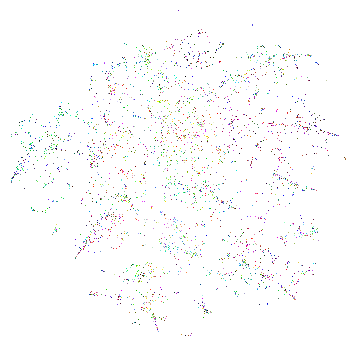

In [55]:
def pack_binary_ica(data, bits_per_channel=8):
    bits_per_color = 3 * bits_per_channel
    ica = FastICA(n_components=bits_per_color, max_iter=500)
    ica_projection = ica.fit_transform(data)
    return projection_to_colors(ica_projection, bits_per_channel)

%time colors = pack_binary_ica(data128, 8)
plot_tsne(data2, colors)

## K-Means

Another approach that shows up in the [LargeVis Paper](https://arxiv.org/abs/1602.00370) is to compute K-Means on the high dimensional data and then use those labels as color indices. We can try with 8, 30, and 128 cluster K-Means.

Wall time: 146 ms


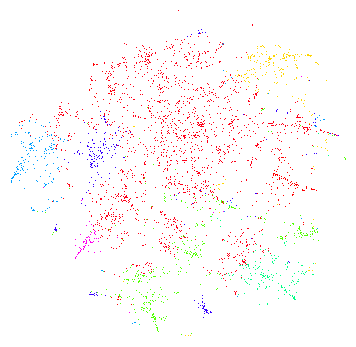

In [56]:
kmeans = MiniBatchKMeans(n_clusters=8)
%time labels = kmeans.fit_predict(data128)
plot_tsne(data2, labels)

Wall time: 181 ms


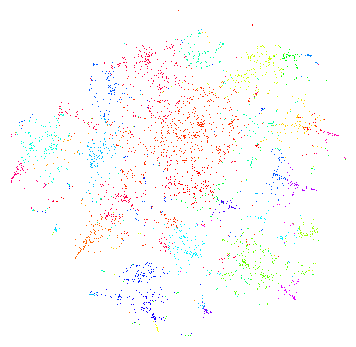

In [57]:
kmeans = MiniBatchKMeans(n_clusters=30)
%time labels = kmeans.fit_predict(data128)
plot_tsne(data2, labels)

Wall time: 1.27 s


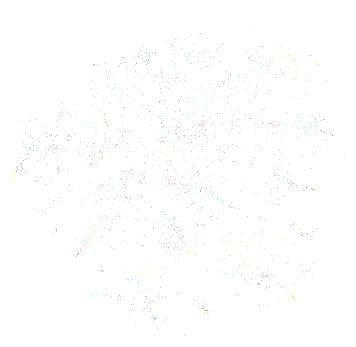

In [18]:
kmeans = MiniBatchKMeans(n_clusters=128)
%time labels = kmeans.fit_predict(data128)
plot_tsne(data2, labels)

Some of the "boundaries" between colors seem fairly arbitrary, but K-Means has a nice property of allowing us to identify the centers of these color regions if we want to provide exemplars.

Wall time: 82.1 ms
Wall time: 177 ms


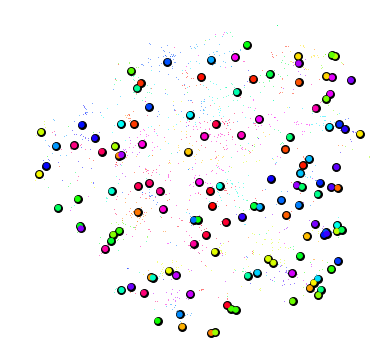

In [19]:
neighbors = NearestNeighbors(n_neighbors=1, metric='euclidean')
%time neighbors.fit(data128)
%time distances, indices = neighbors.kneighbors(kmeans.cluster_centers_)

plt.figure(figsize=(6,6), facecolor='white')
plt.margins(0)
plt.axis('off')
fig = plt.scatter(data2[:,0], data2[:,1], alpha=0.5, marker=',', s=0.5, lw=0, edgecolor='', c=labels, cmap='hsv')
plt.scatter(data2[indices,0], data2[indices,1], marker='.', s=250, c=(0,0,0))
plt.scatter(data2[indices,0], data2[indices,1], marker='.', s=100, c=labels[indices], cmap='hsv')
plt.show()

sklearn.neighbors can be slow, but the mrpt library is much faster.

```python
import mrpt
data128f32 = data128.astype(np.float32)
%time nn = mrpt.MRPTIndex(data128f32, depth=5, n_trees=100)
%time nn.build()
def kneighbors(nn, queries, k, votes_required=4):
    return np.asarray([nn.ann(query, k, votes_required=votes_required) for query in queries])
%time indices = kneighbors(nn, data128f32[:100], 10)
```

## argmax

Another technique, arguably the most evocative, is to use the argmax of each high dimensional vector. The motivation for using argmax is that high dimensional data is so sparse that "nearby" points should have a similar ordering of their dimensions: if you sorted the dimensions of two nearby points, the difference should be small. This means that their argmax (the largest dimensions) should probably be shared. If we do this without any modification to the high dimensional data, we get a fairly homogenous plot:

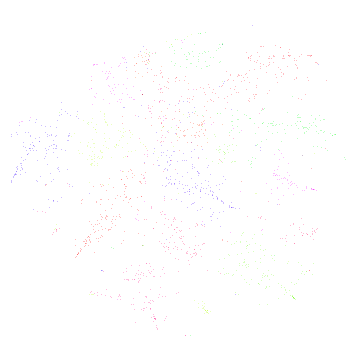

In [20]:
plot_tsne(data2, np.argmax(data128, axis=1))

This is because a few dimensions dominate the argmax.

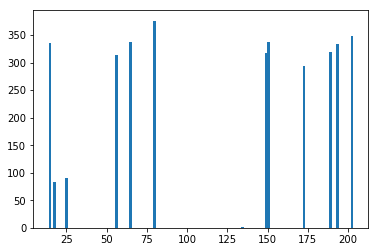

In [21]:
plt.hist(np.argmax(data128, axis=1), bins=128)
plt.show()

If we standardize each dimension then there is a more even distribution of possible argmax values, and therefore more even distribution of colors.

In [22]:
def standardize(data):
    std = np.copy(data)
    std -= std.mean(axis=0)
    std /= std.std(axis=0)
    return std

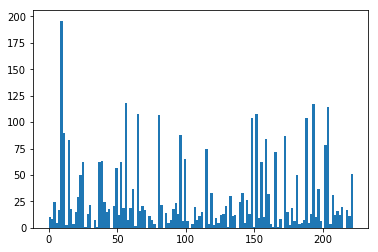

In [23]:
data128_standardized = standardize(data128)
plt.hist(np.argmax(data128_standardized, axis=1), bins=128)
plt.show()

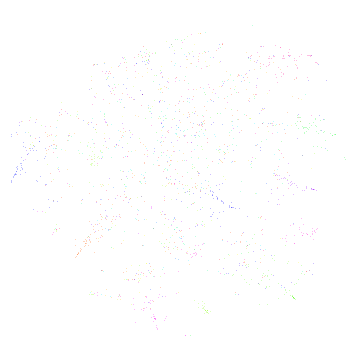

In [24]:
plot_tsne(data2, np.argmax(data128_standardized, axis=1))

In this case the high dimensional data has both negative and positive components, so it might make more sense to take the absolute value before computing the argmax. In this case, it makes things visually "messier" with too many overlapping colors.

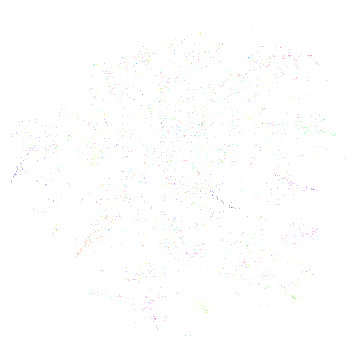

In [25]:
plot_tsne(data2, np.argmax(np.abs(data128_standardized), axis=1))

## PCA + argmax

Because some of the dimensions are correlated with each other in this case, it might make sense to do PCA before taking the argmax. Again if we take the argmax without standardizing the high dimensional data, a few colors dominate.

Wall time: 460 ms


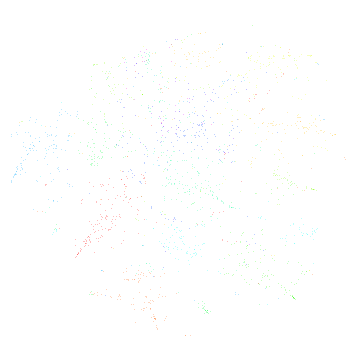

In [26]:
pca = IncrementalPCA(n_components=30)
%time pca_projection = pca.fit_transform(data128)
labels = np.argmax(pca_projection, axis=1)
plot_tsne(data2, labels)

Here we can see the distribution of argmax results are concentrated toward the first dimensions of the PCA projection.

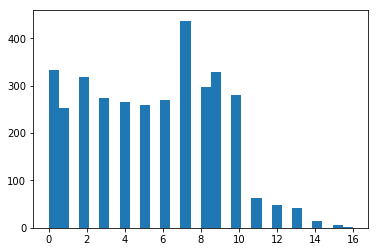

In [27]:
plt.hist(np.argmax(pca_projection, axis=1), bins=30)
plt.show()

Once we standardize it we see a more even distribution.

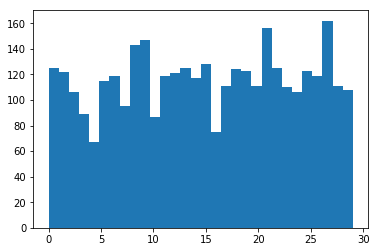

In [28]:
projection_standardized = standardize(pca_projection)
plt.hist(np.argmax(projection_standardized, axis=1), bins=30)
plt.show()

And now we can take the standardized argmax, and the argmax of the absolute values of the standardized data.

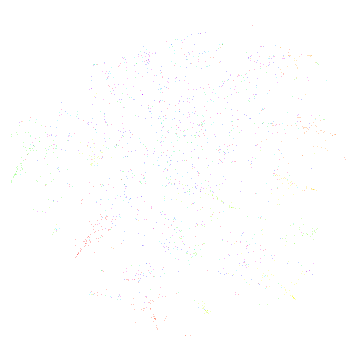

In [29]:
plot_tsne(data2, np.argmax(projection_standardized, axis=1))

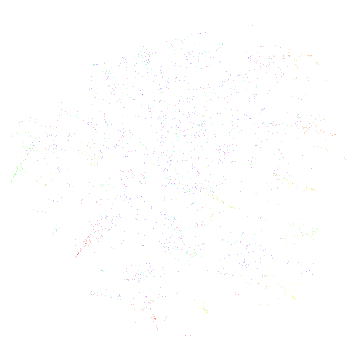

In [30]:
plot_tsne(data2, np.argmax(np.abs(projection_standardized), axis=1))

I prefer the non-absolute value argmax in this case. Now we can run the whole process again for different number of output components from PCA. Here it is for 16 and 128 dimensions.

Wall time: 370 ms


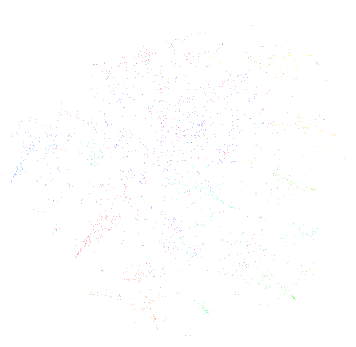

In [31]:
pca = IncrementalPCA(n_components=16)
%time pca_projection = pca.fit_transform(data128)
labels = np.argmax(standardize(pca_projection), axis=1)
plot_tsne(data2, labels)

Wall time: 413 ms


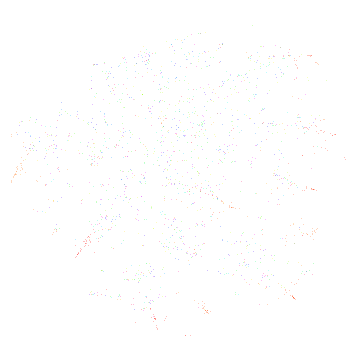

In [32]:
pca = IncrementalPCA(n_components=128)
%time pca_projection = pca.fit_transform(data128)
labels = np.argmax(standardize(pca_projection), axis=1)
plot_tsne(data2, labels)

It should be possible to "tune" the amount of color variation by an element-wise multiplication between each PCA projected vector and a vector with some "falloff" that gives more weight to the earlier dimensions and less weight to the final dimensions.

## ICA + argmax

We can try the same technique, but using ICA instead of PCA. Here for 8, 30, and 128 dimensions.

Wall time: 344 ms


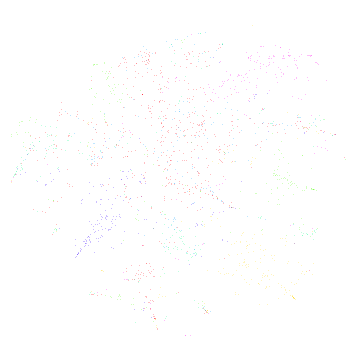

In [33]:
ica = FastICA(n_components=8, max_iter=500)
%time ica_projection = ica.fit_transform(data128)
labels = np.argmax(standardize(ica_projection), axis=1)
plot_tsne(data2, labels)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Wall time: 5.05 s


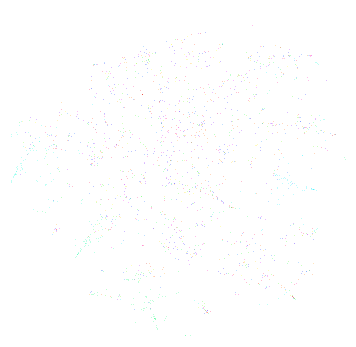

In [34]:
ica = FastICA(n_components=30, max_iter=500)
%time ica_projection = ica.fit_transform(data128)
labels = np.argmax(standardize(ica_projection), axis=1)
plot_tsne(data2, labels)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Wall time: 35.6 s


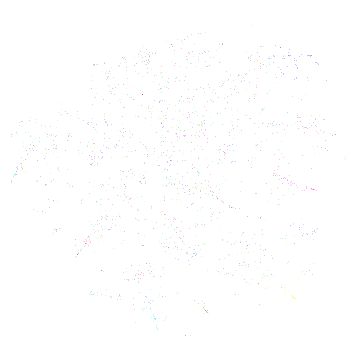

In [35]:
ica = FastICA(n_components=128, max_iter=500)
%time ica_projection = ica.fit_transform(data128)
labels = np.argmax(standardize(ica_projection), axis=1)
plot_tsne(data2, labels)

## ICA/PCA + K-Means

Finally, we can try computing K-Means on top of the dimensionality reduced vectors.

Wall time: 337 ms


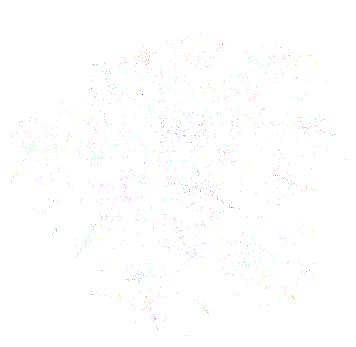

In [36]:
kmeans = MiniBatchKMeans(n_clusters=128)
%time labels = kmeans.fit_predict(pca_projection)
plot_tsne(data2, labels)

Wall time: 415 ms


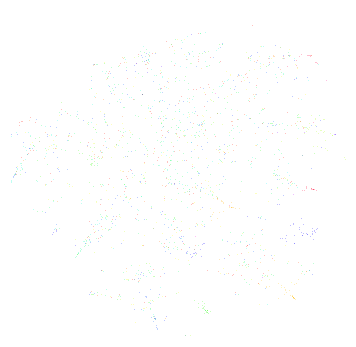

In [37]:
kmeans = MiniBatchKMeans(n_clusters=128)
%time labels = kmeans.fit_predict(ica_projection)
plot_tsne(data2, labels)